In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from datetime import datetime
from scipy.stats import norm

import utils as ut
from improc import *
import worm_env as we
import policy_time as pt

In [198]:
# Goal: write a function that takes a dataframe and rotates all the coordinates.
def get_ring_inds(shape):
    # Takes a matrix shape and returns a list of indices for the outer perimeter.
    indmap = []
    shape = np.array(shape)
    
    indmap.append([0,0])
    for i in np.arange(shape[1]-2)+1:
        indmap.append([0,i])
        
    indmap.append([0,shape[1]-1])
    for i in np.arange(shape[0]-2)+1:
        indmap.append([i,shape[1]-1])
        
    indmap.append([shape[0]-1,shape[1]-1])
    for i in np.arange(shape[1]-2)+1:
        indmap.append([shape[0]-1,shape[1]-1-i])
        
    indmap.append([shape[0]-1,0])
    for i in np.arange(shape[0]-2)+1:
        indmap.append([shape[0]-1-i,0])
    return np.array(indmap)

def make_dict(radius):
    # Makes a dict that rotates an index by about 45 degrees.
    inddict = {}
    shift = 0
    while radius > 0:
        indmap = get_ring_inds((radius*2,radius*2)) + shift
        for i,ind in enumerate(indmap):
            inddict[tuple(ind)] = tuple(indmap[i-radius])
        radius -= 1
        shift += 1
    return {v:k for k,v in inddict.items()}

In [199]:
indmap = make_dict(6)

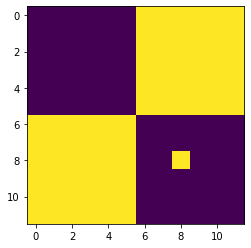

In [200]:
# Make the old deterministic policy with a marker
detpol = np.zeros((12,12))
detpol[6:,:6]+=1
detpol[:6,6:]+=1
detpol[8,8]+=1
plt.imshow(detpol)

In [201]:
# Turn it into a BART-friendly indexed matrix
detwind = np.zeros((144,3))
for i in range(12):
    for j in range(12):
        ind = i*12+j
        detwind[ind,:] = i,j,detpol[i,j]

In [202]:
# Use the rotation dictionary to rotate the policy
new_detwind = np.zeros((144,3))
for i,d in enumerate(detwind):
    new_detwind[i,:] = *indmap[tuple(d[:2])],d[2]

(-0.55, 11.55, -11.55, 0.5500000000000007)

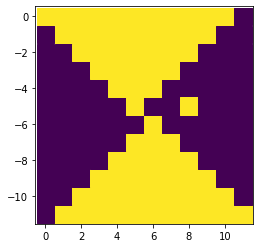

In [203]:
# Show rotated matrix
plt.scatter(new_detwind[:,0],-new_detwind[:,1],c=new_detwind[:,2],marker='s',s=300)
plt.axis('square')

In [204]:
fname = './Data/03_29_0/traj9.npy'
traj = np.load(fname)

In [205]:
traj_rot = traj.copy()
for i,t in enumerate(traj):
    traj_rot[i,:2] = indmap[tuple(t[:2]-1)]

In [206]:
np.save('./Data/03_29_0/traj9rot.npy',traj_rot)

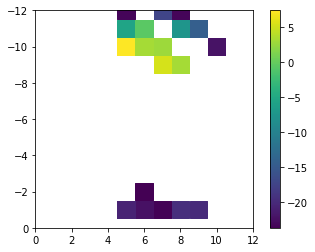

In [212]:
# Show original
plt.scatter(traj[:50,1],-traj[:50,0],c=traj[:50,2],marker='s',s=300)
plt.axis('square');
plt.xlim([0,12])
plt.ylim([0,-12])
plt.colorbar();

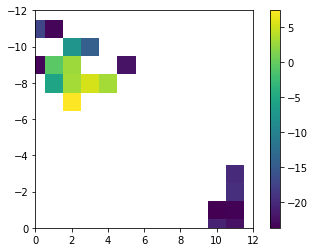

In [213]:
# Show rotated matrix
plt.scatter(traj_rot[:50,1],-traj_rot[:50,0],c=traj_rot[:50,2],marker='s',s=300)
plt.axis('square')
plt.xlim([0,12])
plt.ylim([0,-12])
plt.colorbar();

# Bart results:

varprobs: 

| which | pos_1 | pos_2 |
|---|---|---|
| 0.1157183 | 0.4793551 | 0.4049266 

In [134]:
def get_bart_stats(bart):
    # Takes output of bart or sbart from R.
    b_diff = bart[:,1::2] - bart[:,::2]
    b_mu = np.mean(b_diff,axis=0).reshape(12,12)
    b_std = np.std(b_diff,axis=0).reshape(12,12)
    return b_diff,b_mu,b_std

In [398]:
bart = np.load('./Data/03_29_0/bartrot9.npy')

In [399]:
bd,bmu,bsig = get_bart_stats(bart)

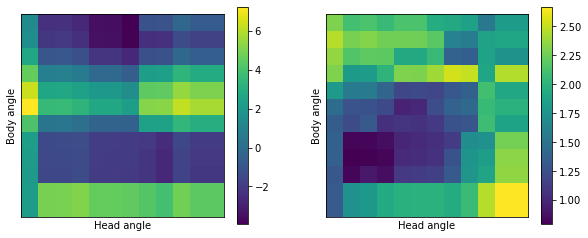

In [400]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches((10,4))
b_st = [bmu,bsig]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([]);
    ax[i].set_xlabel('Head angle')
    ax[i].set_ylabel('Body angle');

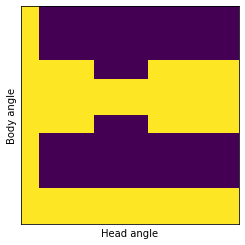

In [402]:
plt.imshow(np.sign(bmu))
plt.xticks([])
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');

In [392]:
rotdf = pd.DataFrame(traj_rot)
roton = rotdf[rotdf[3]==1]
rotoff = rotdf[rotdf[3]==0]

In [393]:
groupedon = roton.groupby([0,1]).agg('mean').reset_index()
groupedoff = rotoff.groupby([0,1]).agg('mean').reset_index()

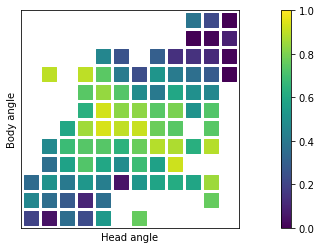

In [394]:
grouped = groupedon
on_arr = np.zeros((12,12))
col = plt.cm.viridis((grouped[2]+20)/40)   
for i in range(len(grouped)):
    plt.scatter(grouped.iloc[i][1],-grouped.iloc[i][0],color=col[i],s=200,marker='s')
    on_arr[int(grouped.iloc[i][0]),int(grouped.iloc[i][1])] = grouped.iloc[i][2]
plt.colorbar();
plt.axis('square');
plt.xticks([])
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');

([], [])

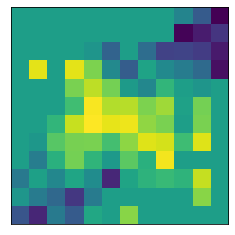

In [342]:
plt.imshow(on_arr)
plt.xticks([])
plt.yticks([])

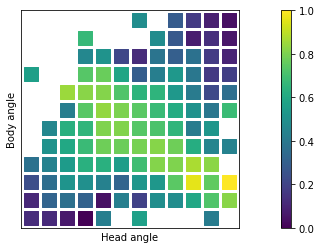

In [395]:
grouped = groupedoff
off_arr = np.zeros((12,12))
col = plt.cm.viridis((grouped[2]+20)/40)   
for i in range(len(grouped)):
    plt.scatter(grouped.iloc[i][1],-grouped.iloc[i][0],color=col[i],s=200,marker='s')
    off_arr[int(grouped.iloc[i][0]),int(grouped.iloc[i][1])] = grouped.iloc[i][2]
plt.colorbar();
plt.axis('square');
plt.xticks([]);
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');

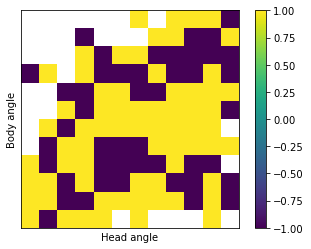

In [396]:
img = np.sign(on_arr-off_arr)
img[img==0] = np.nan
plt.imshow(img)
plt.colorbar();
plt.xticks([])
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');

### Unrotated

In [368]:
rotdf = pd.DataFrame(traj)
roton = rotdf[rotdf[3]==1]
rotoff = rotdf[rotdf[3]==0]

In [369]:
groupedon = roton.groupby([0,1]).agg('mean').reset_index()
groupedoff = rotoff.groupby([0,1]).agg('mean').reset_index()

In [370]:
print(np.max(groupedon[2]),np.min(groupedon[2]))
print(np.max(groupedoff[2]),np.min(groupedoff[2]))

17.607917163017845 -22.441816373679853
20.115991467191407 -21.426775632345052


Text(0.5, 1.0, 'Light on')

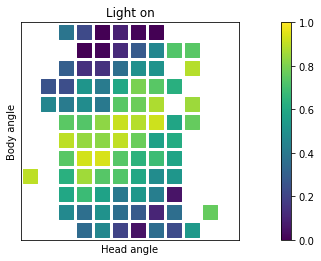

In [389]:
grouped = groupedon
on_arr = np.zeros((12,12))
col = plt.cm.viridis((grouped[2]+20)/40)   
for i in range(len(grouped)):
    plt.scatter(grouped.iloc[i][1]-1,-(grouped.iloc[i][0]-1),color=col[i],s=200,marker='s')
    on_arr[int(grouped.iloc[i][0])-1,int(grouped.iloc[i][1])-1] = grouped.iloc[i][2]
plt.colorbar();
plt.axis('square');
plt.xticks([])
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');
plt.title('Light on')

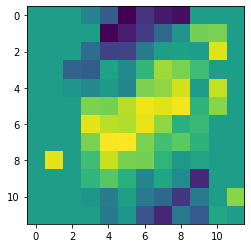

In [322]:
plt.imshow(on_arr)

Text(0.5, 1.0, 'Light off')

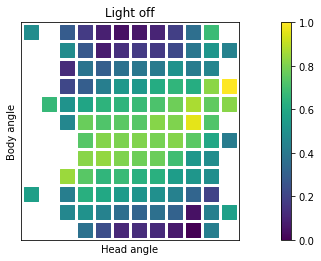

In [388]:
grouped = groupedoff
off_arr = np.zeros((12,12))
col = plt.cm.viridis((grouped[2]+20)/40)   
for i in range(len(grouped)):
    plt.scatter(grouped.iloc[i][1]-1,-(grouped.iloc[i][0]-1),color=col[i],s=200,marker='s')
    off_arr[int(grouped.iloc[i][0])-1,int(grouped.iloc[i][1])-1] = grouped.iloc[i][2]
plt.colorbar();
plt.axis('square');
plt.xticks([])
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');
plt.title('Light off')

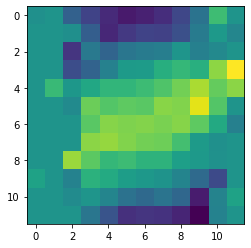

In [328]:
plt.imshow(off_arr)

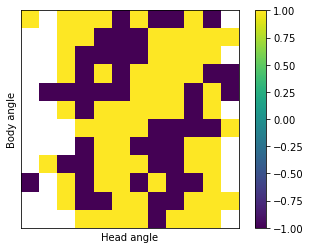

In [387]:
img = np.sign(on_arr-off_arr)
img[img==0] = np.nan
plt.imshow(img)
plt.colorbar();
plt.xticks([])
plt.yticks([]);
plt.xlabel('Head angle')
plt.ylabel('Body angle');

varprobs: 

| which | pos_1 | pos_2 |
|---|---|---|
| 0.1039080 | 0.5403849 | 0.3557071 |

In [377]:
bart = np.load('./Data/03_29_0/barttest9.npy')

In [378]:
bd,bmu,bsig = get_bart_stats(bart)

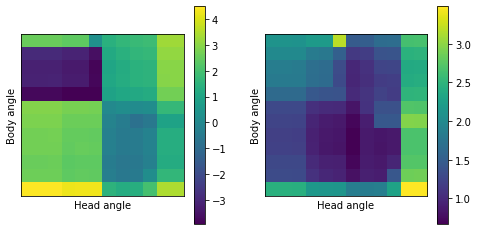

In [386]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches((8,4))
b_st = [bmu,bsig]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([]);
    ax[i].set_xlabel('Head angle')
    ax[i].set_ylabel('Body angle');

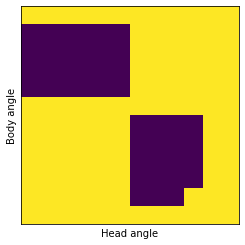

In [390]:
#plt.figure(figsize=(2,2))
plt.imshow(np.sign(bmu))
plt.xticks([])
plt.yticks([])
plt.xlabel('Head angle')
plt.ylabel('Body angle');

# Features

In [360]:
darts = np.array([
    0.0760626, 0.8007254, 0.1232120, 
    0.03950637, 0.73403097, 0.22646266, 
    0.02794029, 0.70856799, 0.26349173 ,
    0.06681464, 0.67959950, 0.25358586,
    0.09408135 ,0.59970736 ,0.30621129 ,
    0.1185039 ,0.6052768 ,0.2762193 ,
    0.1040186 ,0.6103571 ,0.2856243,
    0.1098154 ,0.5597758 ,0.3304088 ,
    0.1115956 ,0.5215856 ,0.3668188 ,
    0.1006999 ,0.5887375 ,0.3105626 ,
])
darts_ = np.array([
    0,0.9840543,0.0159457,
    0,0.91349733,0.08650267,
    0,0.93896705, 0.06103295 ,
    0,0.8250622, 0.1749378 ,
    0,0.7575651, 0.2424349 ,
])

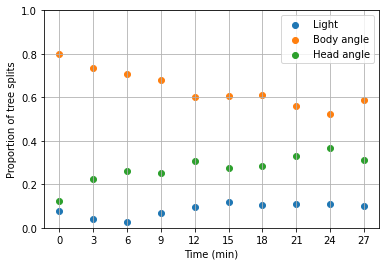

In [366]:
darts = darts.reshape(-1,3)
[plt.scatter(range(10),darts[:,i]) for i in range(3)]
plt.legend(['Light','Body angle','Head angle']);
plt.xlabel('Time (min)')
plt.xticks(range(10),np.arange(0,30,3));
plt.ylabel('Proportion of tree splits');
plt.grid();
plt.ylim([0,1]);

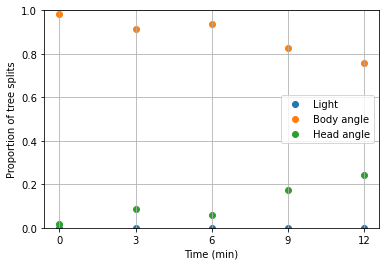

In [367]:
darts_ = darts_.reshape(-1,3)
[plt.scatter(range(5),darts_[:,i]) for i in range(3)]
plt.legend(['Light','Body angle','Head angle']);
plt.xlabel('Time (min)')
plt.xticks(range(5),np.arange(0,15,3));
plt.ylabel('Proportion of tree splits');
plt.grid();
plt.ylim([0,1]);